In [ ]:
Logistic回归模型函数说明
LogisticRegression(tol=0.0001, fit_intercept=True, class_weight=None, max_iter=100)
tol：用于指定模型跌倒收敛的阈值
fit_intercept：bool类型参数，是否拟合模型的截距项，默认为True
class_weight：用于指定因变量类别的权重，如果为字典，则通过字典的形式{class_label:weight}传递每个类别的权重；
              如果为字符串'balanced'，则每个分类的权重与实际样本中的比例成反比，当各分类存在严重不平衡时，设置为'balanced'会比较好；
              如果为None，则表示每个分类的权重相等
max_iter：指定模型求解过程中的最大迭代次数， 默认为100

In [2]:
# 导入第三方模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 自定义绘制ks曲线的函数
def plot_ks(y_test, y_score, positive_flag):
    # 对y_test重新设置索引
    y_test.index = np.arange(len(y_test))
    # 构建目标数据集
    target_data = pd.DataFrame({'y_test':y_test, 'y_score':y_score})
    # 按y_score降序排列
    target_data.sort_values(by = 'y_score', ascending = False, inplace = True)
    # 自定义分位点
    cuts = np.arange(0.1,1,0.1)
    # 计算各分位点对应的Score值
    index = len(target_data.y_score)*cuts
    scores = np.array(target_data.y_score)[index.astype('int')]
    # 根据不同的Score值，计算Sensitivity和Specificity
    Sensitivity = []
    Specificity = []
    for score in scores:
        # 正例覆盖样本数量与实际正例样本量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        # 负例覆盖样本数量与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
    # 构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity), 
                              'ks':np.array(Sensitivity)-(1-np.array(Specificity))})
    # 寻找Sensitivity和1-Specificity之差的最大值索引
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
    # 添加参考线
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index], 
               ymax = plot_data.y2[max_ks_index], linestyles = '--')
    # 添加文本信息
    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
    # 显示图例
    plt.legend()
    # 显示图形
    plt.show()

C:\Users\WGW\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


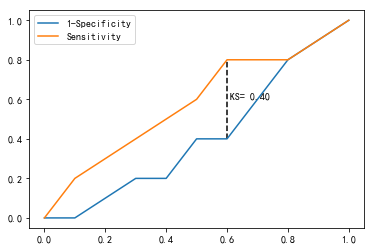

In [3]:
# 导入虚拟数据
virtual_data = pd.read_excel(r'virtual_data.xlsx')
# 应用自定义函数绘制k-s曲线
plot_ks(y_test = virtual_data.Class, y_score = virtual_data.Score,positive_flag = 'P')

In [4]:
# 导入第三方模块
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model

# 读取数据
sports = pd.read_csv(r'Run or Walk.csv')
# 提取出所有自变量名称
predictors = sports.columns[4:]
# 构建自变量矩阵
X = sports.ix[:,predictors]
# 提取y变量值
y = sports.activity
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 1234)

# 利用训练集建模
sklearn_logistic = linear_model.LogisticRegression()
sklearn_logistic.fit(X_train, y_train)
# 返回模型的各个参数
print(sklearn_logistic.intercept_, sklearn_logistic.coef_)

C:\Users\WGW\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


[4.35613952] [[ 0.48533325  6.86221041 -2.44611637 -0.01344578 -0.1607943   0.13360777]]


In [5]:
# 模型预测
sklearn_predict = sklearn_logistic.predict(X_test)
# 预测结果统计
pd.Series(sklearn_predict).value_counts()

0    12121
1    10026
dtype: int64

In [6]:
# 导入第三方模块
from sklearn import metrics
# 混淆矩阵
cm = metrics.confusion_matrix(y_test, sklearn_predict, labels = [0,1])
cm

array([[9971, 1120],
       [2150, 8906]], dtype=int64)

In [7]:
Accuracy = metrics.scorer.accuracy_score(y_test, sklearn_predict)
Sensitivity = metrics.scorer.recall_score(y_test, sklearn_predict)
Specificity = metrics.scorer.recall_score(y_test, sklearn_predict, pos_label=0)
print('模型准确率为%.2f%%:' %(Accuracy*100))
print('正例覆盖率为%.2f%%' %(Sensitivity*100))
print('负例覆盖率为%.2f%%' %(Specificity*100))

模型准确率为85.24%:
正例覆盖率为80.55%
负例覆盖率为89.90%


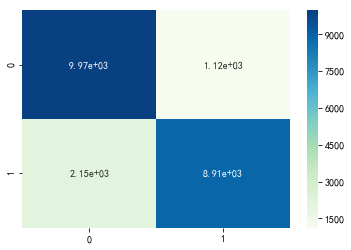

In [8]:
# 混淆矩阵的可视化
# 导入第三方模块
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib
# 绘制热力图
sns.heatmap(cm, annot = True, fmt = '.2e', cmap = 'GnBu')
# 图形显示
plt.show()

In [9]:
sklearn_logistic.predict_proba(X_test)

array([[0.46048548, 0.53951452],
       [0.94650097, 0.05349903],
       [0.91585343, 0.08414657],
       ...,
       [0.93273396, 0.06726604],
       [0.80920741, 0.19079259],
       [0.05483416, 0.94516584]])

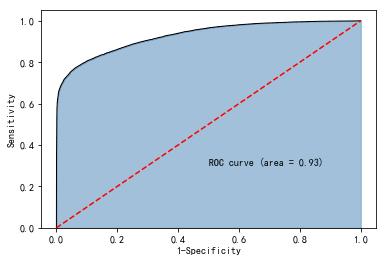

In [10]:
# y得分为模型预测正例的概率
y_score = sklearn_logistic.predict_proba(X_test)[:,1]
# 计算不同阈值下，fpr和tpr的组合值，其中fpr表示1-Specificity，tpr表示Sensitivity
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

C:\Users\WGW\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


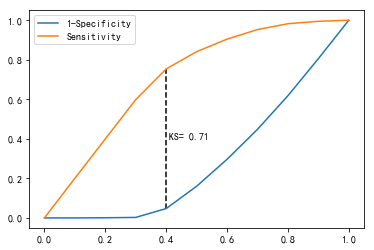

In [11]:
# 调用自定义函数，绘制K-S曲线
plot_ks(y_test = y_test, y_score = y_score, positive_flag = 1)

In [12]:
# -----------------------第一步 建模 ----------------------- #
# 导入第三方模块
import statsmodels.api as sm
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 1234)
# 为训练集和测试集的X矩阵添加常数列1
X_train2 = sm.add_constant(X_train)
X_test2 = sm.add_constant(X_test)
# 拟合Logistic模型
sm_logistic = sm.Logit(y_train, X_train2).fit()
# 返回模型的参数
sm_logistic.params

Optimization terminated successfully.
         Current function value: 0.324875
         Iterations 8


const             4.388537
acceleration_x    0.489617
acceleration_y    6.906590
acceleration_z   -2.459638
gyro_x           -0.014715
gyro_y           -0.161164
gyro_z            0.134655
dtype: float64

In [13]:
# -----------------------第二步 预测构建混淆矩阵 ----------------------- #
# 模型在测试集上的预测
sm_y_probability = sm_logistic.predict(X_test2)
# 根据概率值，将观测进行分类，以0.5作为阈值
sm_pred_y = np.where(sm_y_probability >= 0.5, 1, 0)
# 混淆矩阵
cm = metrics.confusion_matrix(y_test, sm_pred_y, labels = [0,1])
cm

array([[9967, 1124],
       [2149, 8907]], dtype=int64)

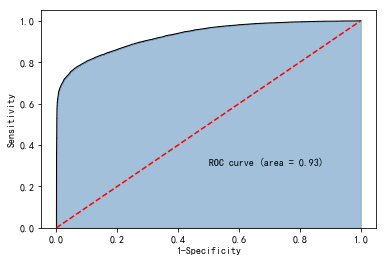

In [14]:
# -----------------------第三步 绘制ROC曲线 ----------------------- #
# 计算真正率和假正率 
fpr,tpr,threshold = metrics.roc_curve(y_test, sm_y_probability)
# 计算auc的值  
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()
# 图中的红色线为参考线，即在不使用模型的情况下，Sensitivity 和 1-Specificity 之比恒等于 1。
# 通常绘制ROC曲线，不仅仅是得到左侧的图形，更重要的是计算折线下的面积，即图中的阴影部分，这个面积称为AUC。
# 在做模型评估时，希望AUC的值越大越好，通常情况下，当AUC在0.8以上时，模型就基本可以接受了。

C:\Users\WGW\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


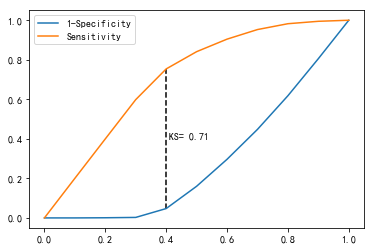

In [15]:
# -----------------------第四步 绘制K-S曲线 ----------------------- #
# 调用自定义函数，绘制K-S曲线
sm_y_probability.index = np.arange(len(sm_y_probability))
plot_ks(y_test = y_test, y_score = sm_y_probability, positive_flag = 1)
# 图中的两条折线分别代表各分位点下的正例覆盖率和1-负例覆盖率，通过两条曲线很难对模型的好坏做评估，一般会选用最大的KS值作为衡量指标。
# KS的计算公式为：KS= Sensitivity-(1- Specificity)= Sensitivity+Specificity-1。
# 对于KS值而言，也是希望越大越好，通常情况下，当KS值大于0.4时，模型基本可以接受。